In [ ]:
#|hide
## If running in colab, set things up with:
# !pip install -q tglcourse
# !git clone https://github.com/johnowhitaker/tglcourse
# %cd tglcourse

# Lesson 5: Exploring Multiple Modalities with CLIP

## CLIP: Introduction

In [ ]:
#|hide
from tglcourse.utils import *
import torch
import torchvision
import IPython.display as ipd
from tqdm.auto import tqdm

In [ ]:
#|echo: false
ipd.display(ipd.IFrame(src="https://www.youtube.com/embed/7fMHXSKqkZE", width="560", height="315"))

CLIP:
- concepts
- embedding text and images
- measuring similarity
- Use as a loss (imstack demo)
- Need for transformations
- export some functions for later
- CLOOB

CLIP (Contrastive Language-Image Pre-training) is a method created by OpenAI for training models capable of aligning image and text representations. Images and text are drastically different modalities, but CLIP manages to map both to a shared space, allowing for all kinds of neat tricks. 

![clip diagram](https://api.wandb.ai/files/johnowhitaker/images/projects/37054863/8c556981.png)

During training, CLIP takes in image-caption pairs. The images are fed through an image encoder model (based on a resnet or ViT backbone) and transformed into an embedding vector (I in the diagram above). A second model (typically a transformer model of some sort) takes the text and transforms it into an embedding vector (T in the diagram).

Crucially, both these embeddings are the same shape, allowing for direct comparison. Given a batch of image-caption pairs, CLIP tries to maximize the similarity of image and text embeddings that go together (the blue diagonal in the diagram) while minimizing the similarity between non-related pairs. 

In this lesson we're going to explore some of the use-cases for a model like this, using an open CLIP implementation called OpenCLIP. If you'd like to read some more background on OpenCLIP and see some benchmarks I ran with some of the pretrained models, check out [this report I wrote on the subject](https://wandb.ai/johnowhitaker/openclip-benchmarking/reports/Exploring-OpenCLIP--VmlldzoyOTIzNzIz).


## Loading CLIP models with OpenCLIP

You can use pretrained CLIP models in a few different ways. There is [OpenAI's github repository](https://github.com/openai/CLIP) or the HuggingFace implementations, but I like the [OpenCLIP project](https://github.com/mlfoundations/open_clip) which includes both OpenAI versions and a number of new models trained in the open on public datasets like LAION. 

Let's import the library and see what models are available:

In [ ]:
import open_clip

print(open_clip.list_pretrained())

[('RN50', 'openai'), ('RN50', 'yfcc15m'), ('RN50', 'cc12m'), ('RN50-quickgelu', 'openai'), ('RN50-quickgelu', 'yfcc15m'), ('RN50-quickgelu', 'cc12m'), ('RN101', 'openai'), ('RN101', 'yfcc15m'), ('RN101-quickgelu', 'openai'), ('RN101-quickgelu', 'yfcc15m'), ('RN50x4', 'openai'), ('RN50x16', 'openai'), ('RN50x64', 'openai'), ('ViT-B-32', 'openai'), ('ViT-B-32', 'laion400m_e31'), ('ViT-B-32', 'laion400m_e32'), ('ViT-B-32', 'laion2b_e16'), ('ViT-B-32', 'laion2b_s34b_b79k'), ('ViT-B-32-quickgelu', 'openai'), ('ViT-B-32-quickgelu', 'laion400m_e31'), ('ViT-B-32-quickgelu', 'laion400m_e32'), ('ViT-B-16', 'openai'), ('ViT-B-16', 'laion400m_e31'), ('ViT-B-16', 'laion400m_e32'), ('ViT-B-16-plus-240', 'laion400m_e31'), ('ViT-B-16-plus-240', 'laion400m_e32'), ('ViT-L-14', 'openai'), ('ViT-L-14', 'laion400m_e31'), ('ViT-L-14', 'laion400m_e32'), ('ViT-L-14', 'laion2b_s32b_b82k'), ('ViT-L-14-336', 'openai'), ('ViT-H-14', 'laion2b_s32b_b79k'), ('ViT-g-14', 'laion2b_s12b_b42k'), ('roberta-ViT-B-32', 'la

Following the demo code on GitHub, here's how we load a model:

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

100%|████████████████████████████████████████| 605M/605M [00:05<00:00, 109MiB/s]


### Aside: Model Naming

What does 'ViT-B/32' mean? This uses a Vision Transformer (ViT) as the image encoder, with an image patch size of 32 (larger patch size means fewer patches per image at a given size, and thus faster/smaller models) and the 'Base' size model. I believe the size order is 'Base' (B), Large (L), Huge (H) and ginormous (g) but don't quote me on that! Generally the larger models with the smaller patch sizes will need more memory and compute in exchenge for better performance. Most models were trained on 224px input images but there are variants trained on larger image sizes - again they will be more computationally expensive to run. 'RN50' style names mean the vision encoder is based on a Resnet50 architecture instead of a vision transformer. 

Generally I like to stick with the smaller models, but you can experiment with swapping in larger variants or using multiple models and combining the results.

## Preprocessing

We want to prepare our image inputs to match the data used for training. In most cases, this involves resizing to 224px square images and normalizing the image data:

In [ ]:
preprocess # View the preprocessing function loaded with the model above

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Image -> Features

We can load in an image and pre-process it with this function, and then use `model.encode_image` to turn it into a CLIP embedding:

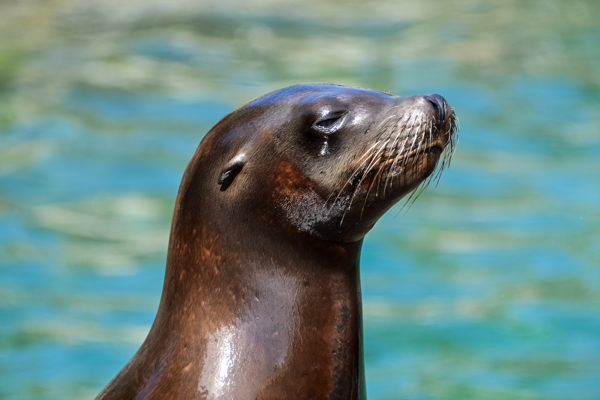

In [ ]:
input_image = pil_from_url('https://images.pexels.com/photos/185032/pexels-photo-185032.jpeg?').resize((600, 400))
input_image

In [ ]:
image = preprocess(input_image).unsqueeze(0)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    
print('image.shape:', image.shape, 'image_features.shape:', image_features.shape)

image.shape: torch.Size([1, 3, 224, 224]) image_features.shape: torch.Size([1, 512])


## Text -> Features

For text inputs, we first tokenize them (something you'll learn more about in lesson 9) and then encode them with the `encode_text` method. Note that the resulting embeddings have the same number of dimensions as the image embedding above (512 in this case):

In [ ]:
text = open_clip.tokenize(["a diagram", "a dog", "a cat"])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
    
print('Tokenized text shape:', text.shape)
print('text_features.shape', text_features.shape)

Tokenized text shape: torch.Size([3, 77])
text_features.shape torch.Size([3, 512])


## Computing Similarity

Once we have representations of both images and text in the same space, we can compare them! Here's how we might compare the three texts above with the seal image:

In [ ]:
# Computing similarities
def probability_scores(image_features, text_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (image_features @ text_features.T).softmax(dim=-1)
    return text_probs

torch.set_printoptions(precision=3)
print("Label probs:", probability_scores(image_features, text_features))  # Apparently the closest guess is 'a dog' - do you agree?

Label probs: tensor([[0.330, 0.342, 0.328]])


Apparently the seal looks like a dog (the middle probability is higher). What is going on here?

This operation is very similar to the Cosine Similarity we saw in lesson 4. Specifically, the following two calulations are identical:

In [ ]:
(image_features/image_features.norm(dim=-1, keepdim=True))@(text_features/text_features.norm(dim=-1, keepdim=True)).T

tensor([[0.143, 0.180, 0.138]])

In [ ]:
torch.nn.functional.cosine_similarity(image_features, text_features)

tensor([0.143, 0.180, 0.138])

So we're calculating the cosine similarity between the image and each text, giving the values above. The final step in the classification demo is to run this through a softmax operation which will scale the values so that they sum to 1, allowing us to interpret them as probabilities:

In [ ]:
torch.nn.functional.cosine_similarity(image_features, text_features).softmax(dim=-1)

tensor([0.330, 0.342, 0.328])

## Image Search

We can take advantage of this similarity measure for image search too! If you want to see an impressive large-scale version in action, check out the [CLIP retrieval tool](https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn5.laion.ai&index=laion5B&useMclip=false) which lets you search LAION. For our demo let's just search the images folder of this course:

In [ ]:
# Finding image files
import glob
image_files = glob.glob('images/*.png') + glob.glob('images/*.jpeg')
len(image_files)

12

In [ ]:
# Claculating their CLIP embeddings
image_features = []
for fn in image_files:
    im = load_image_pil(fn)
    image_features.append(model.encode_image(preprocess(im).unsqueeze(0)))
image_features = torch.cat(image_features)
image_features.shape

torch.Size([12, 512])

Similarities: [0.12317517 0.07264645 0.07863379 0.11897033 0.0889878  0.07535253
 0.07106286 0.11585622 0.12133323 0.12665415 0.27785698 0.13541897]
Argmax: tensor(10)
Best image match:


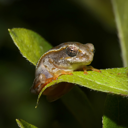

In [ ]:
# Embedding a query text and finding the image with the highest similarity
text = open_clip.tokenize(["a frog"])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
similarities = torch.nn.functional.cosine_similarity(text_features, image_features)
print('Similarities:', similarities.detach().numpy())
print('Argmax:', similarities.argmax()) # TODO explain
print('Best image match:')
load_image_pil(image_files[similarities.argmax()]).resize((128, 128))

Pretty nifty! Now, what if instead of searching images we want to GENERATE them?

## Using CLIP as a loss function

Let's try optimizing the pixels of an image to mazimise the similarity of the image with a text prompt:

  0%|          | 0/250 [00:00<?, ?it/s]

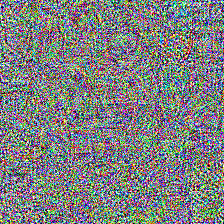

In [ ]:
device = 'cuda'
model.to(device)

text = open_clip.tokenize(["a picture of a frog"]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
    
im = torch.rand(1, 3, 224, 224).to(device)
start_im = im.clone() # Keep a copy of the initial noise image
im.requires_grad = True

normalize = torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

opt = torch.optim.Adam([im], lr=1e-2)
losses = []

for i in tqdm(range(250)):
    image_features = model.encode_image(normalize(im))
    sim = torch.nn.functional.cosine_similarity(text_features, image_features)
    loss = 1-sim # So lower is better
    loss.backward()
    losses.append(loss.item())
    opt.step()
    opt.zero_grad()
    
tensor_to_pil(im)

[<matplotlib.lines.Line2D>]

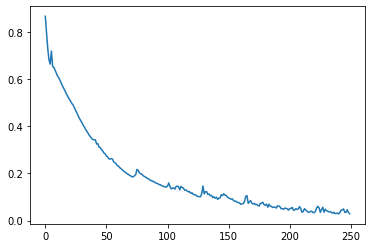

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

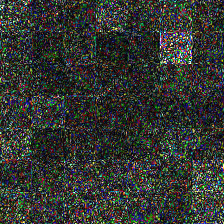

In [ ]:
tensor_to_pil(torch.abs(start_im - im)*2) # Viewing the difference between the start image and the final result

Woah - what's going on here?

- Some values in our image are > 1, which is not ideal
- The CLIP model we're using here is absed on a Vision Trnasformer, which works with image patches. You can see the patches in the difference image above - since each patch is seeing the same pixels all the time, those pixels can go crazy getting just the right output for that patch.
- That learning rate might be a little high - you can try it lower or play with optmiizing for more iterations.

So, how do we fix all of this? Here's a few improvements we can make:

Improvements: 
- Changing our loss to something called the Great Circle Distance Squared
- Applying some transforms to the image before feeding it to CLIP, such that the model sees a slightly different version of the image each time
- Forcing the values to lie in the expected range for an image with `im.clip(0, 1)`.

  0%|          | 0/350 [00:00<?, ?it/s]

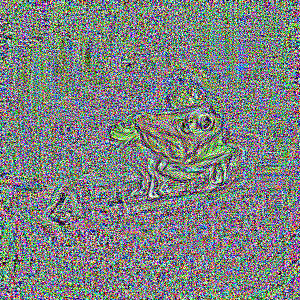

In [ ]:
text = open_clip.tokenize(["a picture of a frog"]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
    
im = torch.rand(1, 3, 300, 300).to(device) # Larger image
start_im = im.clone() # Keep a copy of the initial noise image
im.requires_grad = True

# Our new and improved loss function
def clip_loss(image_features, text_features):
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed =torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
    return dists.mean()

tfms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # Random CROP each time
    torchvision.transforms.RandomAffine(5),
    # torchvision.transforms.ColorJitter(), # You can experiment with different ones here
    # torchvision.transforms.GaussianBlur(5), 
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

opt = torch.optim.Adam([im], lr=5e-3)
losses = []

for i in tqdm(range(350)):
    image_features = model.encode_image(tfms(im))
    loss = clip_loss(image_features, text_features)
    loss.backward()
    losses.append(loss.item())
    opt.step()
    opt.zero_grad()
    
tensor_to_pil(im)


Better but still not amazing! TODO talk about more possible improvementsfrom tglcourse.generation_utils import SirenGenerator, CLIPLossToTargets, optimise

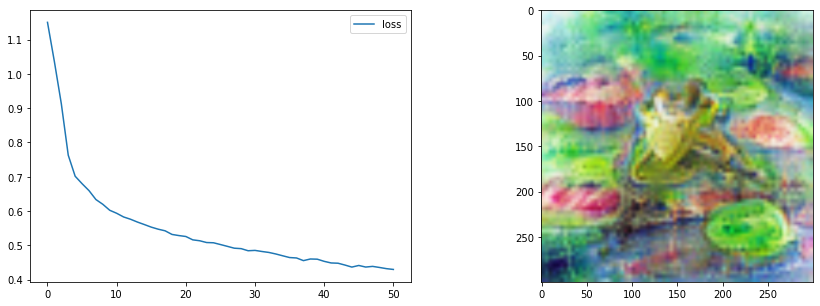

In [ ]:
from tglcourse.generation_utils import ImStackGenerator, CLIPLossToTargets, optimise

# Parameters of the imstack tweaked
gen = ImStackGenerator(size=300,base_size=8,n_layers=3,scale=3,layer_decay = 0.3).to(device)

# A custom optimiser
opt = torch.optim.AdamW(gen.parameters(), lr=0.05, 
                       weight_decay=1e-4) # Weight decay for less extreme values

# Loss function
clip_loss_fn = CLIPLossToTargets(text_prompts=['A watercolor painting of a frog on a lillypad'],
                                 n_cuts=64) # More cuts for smoother loss signal

# Tweak number of steps and use our custom optimiser
optimise(gen, loss_functions=[clip_loss_fn],
         optimizer=opt, n_steps=60)

### TODO video looking at Remi's multi-perceptor notebook.

Page stats: Total Hits: [![HitCount](https://hits.dwyl.com/johnowhitaker/tglcourse.svg?style=flat-square&show=unique)](http://hits.dwyl.com/johnowhitaker/tglcourse)
Page visitors:
![visitor badge](https://page-views.glitch.me/badge?page_id=tglcourse.l05)